<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>Author: [Yury Kashnitsky](https://www.linkedin.com/in/festline/), Data Scientist @ Mail.Ru Group <br>All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #10 (demo)
## <center> Gradient boosting

Your task is to beat at least 2 benchmarks in this [Kaggle Inclass competition](https://www.kaggle.com/c/flight-delays-spring-2018). Here you won’t be provided with detailed instructions. We only give you a brief description of how the second benchmark was achieved using Xgboost. Hopefully, at this stage of the course, it's enough for you to take a quick look at the data in order to understand that this is the type of task where gradient boosting will perform well. Most likely it will be Xgboost, however, we’ve got plenty of categorical features here.

<img src='../../img/xgboost_meme.jpg' width=40% />

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [2]:
train = pd.read_csv('../../data/flight_delays_train.csv')
test = pd.read_csv('../../data/flight_delays_test.csv')

In [3]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Given flight departure time, carrier's code, departure airport, destination location, and flight distance, you have to predict departure delay for more than 15 minutes. As the simplest benchmark, let's take Xgboost classifier and two features that are easiest to take: DepTime and Distance. Such model results in 0.68202 on the LB.

In [5]:
X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

We'll train Xgboost with default parameters on part of data and estimate holdout ROC AUC.

In [6]:
xgb_model = XGBClassifier(seed=17)

xgb_model.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb_model.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

0.7001228548770644

Now we do the same with the whole training set, make predictions to test set and form a submission file. This is how you beat the first benchmark. 

In [7]:
xgb_model.fit(X_train, y_train)
xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]

pd.Series(xgb_test_pred, 
          name='dep_delayed_15min').to_csv('xgb_2feat.csv', 
                                           index_label='id', header=True)

The second benchmark in the leaderboard was achieved as follows:

- Features `Distance` and `DepTime` were taken unchanged
- A feature `Flight` was created from features `Origin` and `Dest`
- Features `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` and `Flight` were transformed with OHE (`LabelBinarizer`)
- Logistic regression and gradient boosting (xgboost) were trained. Xgboost hyperparameters were tuned via cross-validation. First, the hyperparameters responsible for model complexity were optimized, then the number of trees was fixed at 500 and learning step was tuned.
- Predicted probabilities were made via cross-validation using `cross_val_predict`. A linear mixture of logistic regression and gradient boosting predictions was set in the form $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, where $p_{logit}$ is a probability of class 1, predicted by logistic regression, and $p_{xgb}$ – the same for xgboost. $w_1$ weight was selected manually.
- A similar combination of predictions was made for test set. 

Following the same steps is not mandatory. That’s just a description of how the result was achieved by the author of this assignment. Perhaps you might not want to follow the same steps, and instead, let’s say, add a couple of good features and train a random forest of a thousand trees.

Good luck!

## Solution
First, let's new features. I did everything as adviced above. But I did't create new feature Flight because after binarizing labels for Flight I got ~4k features. It caused very time consuming training. So I skip Flight features to speed it up.

In [8]:
from sklearn.preprocessing import LabelBinarizer

month_bin, month_day_bin, week_day_bin, carrier_bin, flight_bin = \
            LabelBinarizer(), LabelBinarizer(), LabelBinarizer(), LabelBinarizer(), LabelBinarizer()
origin_bin, dest_bin = LabelBinarizer(), LabelBinarizer()

# transform features as explained before
X_train = np.hstack([train[['Distance', 'DepTime']].values,
#                      flight_bin.fit_transform(train['Origin'] + train['Dest']),
                     origin_bin.fit_transform(train['Origin']),
                     dest_bin.fit_transform(train['Dest']),
                     month_bin.fit_transform(train['Month']),
                     month_day_bin.fit_transform(train['DayofMonth']),
                     week_day_bin.fit_transform(train['DayOfWeek']),
                     carrier_bin.fit_transform(train['UniqueCarrier'])])

X_test = np.hstack([test[['Distance', 'DepTime']].values,
#                     flight_bin.transform(test['Origin'] + test['Dest']),
                    origin_bin.transform(test['Origin']),
                    dest_bin.transform(test['Dest']),
                    month_bin.transform(test['Month']),
                    month_day_bin.transform(test['DayofMonth']),
                    week_day_bin.transform(test['DayOfWeek']),
                    carrier_bin.transform(test['UniqueCarrier'])])

y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

Train dataset was splited into train and validation subsets.

In [9]:
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

In [10]:
X_train_part.shape

(70000, 652)

With grid search I found parameters set which is better than others.

In [11]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [500],
    'learning_rate': [0.05, 0.1, 0.5],
    'max_depth': [10, 15, 20]
}

xgb_model = XGBClassifier(seed=17)
xgb_gcv = GridSearchCV(xgb_model, parameters, cv=3,
                       n_jobs=-1, verbose=True)
xgb_gcv.fit(X_train_part, y_train_part)

xgb_gcv.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 147.5min finished


{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

parameters = {'C': np.linspace(0, 1, 20)}

lr_scaler = StandardScaler()
lr_gcv = GridSearchCV(LogisticRegression(), parameters,
                      cv=3, n_jobs=-1, verbose=True)
lr_gcv.fit(lr_scaler.fit_transform(X_train_part), y_train_part)
lr_gcv.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.5min finished


{'C': 0.05263157894736842}

RegressionConsolidator was created to find best w-value for mixturing predictions from XGBoost and LinearRegression.

In [13]:
import matplotlib.pyplot as plt


class RegressionConsolidator:
    def __init__(self):
        self.w_ = None
        self.best_score_ = None
        
    def fit(self, y_first, y_second, y_valid):
        scores = []
        ws = np.linspace(0, 1, 100)
        for w in ws:
            y_consolidated = self._consolidate(y_first, y_second, w)
            score = roc_auc_score(y_valid, y_consolidated)
            scores.append(score)
        
        max_index = np.argmax(scores)
        self.w_ = ws[max_index]
        self.best_score_ = scores[max_index]
        
        plt.plot(ws, scores)
        plt.plot([self.w_, self.w_], [np.min(scores), self.best_score_])
        plt.xlabel('w value')
        plt.ylabel('roc-auc value')
        plt.grid()
        plt.show()
        
        return self
            
    def _consolidate(self, y_first, y_second, w):
        return y_first * w + y_second * (1 - w)
    
    def consolidate(self, y_first, y_second):
        if self.w_ is None:
            raise RuntimeError('Coefficient w is not calculated, run fit() method before')
            
        return self._consolidate(y_first, y_second, self.w_)
    
    def fit_consolidate(self, y_first, y_second, y_valid):
        return self.fit(y_first, y_second, y_valid)\
                   .consolidate(y_first, y_second)

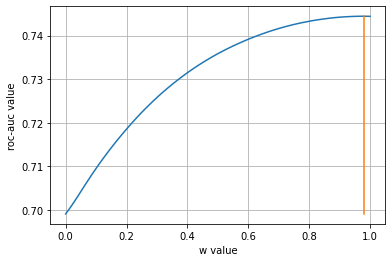

0.9797979797979799 0.7444421469880825


In [14]:
xgb_valid_pred = xgb_gcv.best_estimator_.predict_proba(X_valid)[:, 1]
lr_valid_pred = lr_gcv.best_estimator_.predict_proba(lr_scaler.transform(X_valid))[:, 1]

cons = RegressionConsolidator()
cons.fit(xgb_valid_pred, lr_valid_pred, y_valid)
print(cons.w_, cons.best_score_)

So, the best is w=0.97. We will use it later making predictions on test dataset.

In [15]:
xgb_model = XGBClassifier(**xgb_gcv.best_params_,
                          seed=17, n_jobs=-1)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=17,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [16]:
lr_model = LogisticRegression(**lr_gcv.best_params_)
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.05263157894736842)

In [17]:
xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]
lr_test_pred = lr_model.predict_proba(X_test)[:, 1]
cons_test_pred = cons.consolidate(xgb_test_pred, lr_test_pred)

pd.Series(cons_test_pred, 
          name='dep_delayed_15min').to_csv('xgb_2feat.csv', 
                                           index_label='id', header=True)

<img src='../../img/screencapture-kaggle-c-flight-delays.png' />